In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

In [3]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(786816,2)    
    def forward(self, x):
        x = x.view(x.size(0),-1)
        out = torch.log_softmax(self.linear(x),1)
        return out

In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,data[i],axis=0)
                l += labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54it/s]


Epoch Train Loss: 30.045273  Epoch Train Accuracy: 53.538360  Epoch Test Loss: 20.973218  Epoch Test Accuracy: 54.202279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.23it/s]


Epoch Train Loss: 0.091571  Epoch Train Accuracy: 96.164021  Epoch Test Loss: 4.391396  Epoch Test Accuracy: 53.739316


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92it/s]


Epoch Train Loss: 7.548771  Epoch Train Accuracy: 71.593915  Epoch Test Loss: 12.386788  Epoch Test Accuracy: 46.652422


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.01it/s]


Epoch Train Loss: 1.783679  Epoch Train Accuracy: 84.689153  Epoch Test Loss: 11.777713  Epoch Test Accuracy: 50.356125


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.95it/s]


Epoch Train Loss: 0.311660  Epoch Train Accuracy: 96.511243  Epoch Test Loss: 4.844743  Epoch Test Accuracy: 59.437322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.26it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92it/s]


Epoch Train Loss: 24.863376  Epoch Train Accuracy: 51.556777  Epoch Test Loss: 20.756689  Epoch Test Accuracy: 58.217593


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.19it/s]


Epoch Train Loss: 1.127013  Epoch Train Accuracy: 86.334961  Epoch Test Loss: 6.363652  Epoch Test Accuracy: 58.217593


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16it/s]


Epoch Train Loss: 0.029599  Epoch Train Accuracy: 99.338624  Epoch Test Loss: 3.491556  Epoch Test Accuracy: 62.557870


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


Epoch Train Loss: 0.027721  Epoch Train Accuracy: 99.735450  Epoch Test Loss: 2.293068  Epoch Test Accuracy: 63.194444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch Train Loss: 0.032235  Epoch Train Accuracy: 99.735450  Epoch Test Loss: 1.450237  Epoch Test Accuracy: 62.905093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66it/s]


Epoch Train Loss: 20.000158  Epoch Train Accuracy: 54.100529  Epoch Test Loss: 24.263718  Epoch Test Accuracy: 53.564815


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


Epoch Train Loss: 1.333707  Epoch Train Accuracy: 85.449735  Epoch Test Loss: 4.252127  Epoch Test Accuracy: 61.481481


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.01it/s]


Epoch Train Loss: 1.625929  Epoch Train Accuracy: 84.656085  Epoch Test Loss: 5.727641  Epoch Test Accuracy: 59.583333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch Train Loss: 0.962483  Epoch Train Accuracy: 90.476190  Epoch Test Loss: 6.419796  Epoch Test Accuracy: 58.518519


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.19it/s]


Epoch Train Loss: 0.491171  Epoch Train Accuracy: 94.047619  Epoch Test Loss: 7.993667  Epoch Test Accuracy: 57.916667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.01it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16it/s]


Epoch Train Loss: 42.194397  Epoch Train Accuracy: 51.530612  Epoch Test Loss: 28.994963  Epoch Test Accuracy: 52.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]


Epoch Train Loss: 0.562057  Epoch Train Accuracy: 92.611489  Epoch Test Loss: 4.100236  Epoch Test Accuracy: 61.111111


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49it/s]


Epoch Train Loss: 1.455972  Epoch Train Accuracy: 87.244898  Epoch Test Loss: 8.284224  Epoch Test Accuracy: 48.703704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch Train Loss: 0.027106  Epoch Train Accuracy: 99.735450  Epoch Test Loss: 3.065570  Epoch Test Accuracy: 64.814815


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.55it/s]


Epoch Train Loss: 0.026418  Epoch Train Accuracy: 100.000000  Epoch Test Loss: 1.928566  Epoch Test Accuracy: 61.296296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.80it/s]


Epoch Train Loss: 37.044801  Epoch Train Accuracy: 56.825397  Epoch Test Loss: 68.910821  Epoch Test Accuracy: 51.973684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60it/s]


Epoch Train Loss: 0.386059  Epoch Train Accuracy: 92.804233  Epoch Test Loss: 10.873373  Epoch Test Accuracy: 50.730994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66it/s]


Epoch Train Loss: 2.421650  Epoch Train Accuracy: 80.317460  Epoch Test Loss: 11.314419  Epoch Test Accuracy: 48.806043


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43it/s]


Epoch Train Loss: 0.185573  Epoch Train Accuracy: 96.375661  Epoch Test Loss: 13.943610  Epoch Test Accuracy: 46.637427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.98it/s]


Epoch Train Loss: 0.495806  Epoch Train Accuracy: 93.915344  Epoch Test Loss: 13.024956  Epoch Test Accuracy: 48.952242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66it/s]


Average Train Loss: 0.414581
Average Train Accuracy: 96.269841
Average Test Loss: 6.867408
Average Test Accuracy: 57.037843

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 38.709270  Epoch Train Accuracy: 50.893506  Epoch Test Loss: 9.524174  Epoch Test Accuracy: 62.193362


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.06it/s]


Epoch Train Loss: 0.646078  Epoch Train Accuracy: 89.729870  Epoch Test Loss: 4.597637  Epoch Test Accuracy: 55.266955


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.79it/s]


Epoch Train Loss: 0.548810  Epoch Train Accuracy: 91.075325  Epoch Test Loss: 6.624683  Epoch Test Accuracy: 50.649351


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.14it/s]


Epoch Train Loss: 0.107731  Epoch Train Accuracy: 96.472727  Epoch Test Loss: 3.997858  Epoch Test Accuracy: 56.998557


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.56it/s]


Epoch Train Loss: 0.099887  Epoch Train Accuracy: 96.883117  Epoch Test Loss: 5.720969  Epoch Test Accuracy: 56.277056


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.61it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.74it/s]


Epoch Train Loss: 21.999914  Epoch Train Accuracy: 53.376623  Epoch Test Loss: 12.018563  Epoch Test Accuracy: 61.255411


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.26it/s]


Epoch Train Loss: 0.839972  Epoch Train Accuracy: 88.896104  Epoch Test Loss: 3.852776  Epoch Test Accuracy: 59.090909


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.51it/s]


Epoch Train Loss: 0.251946  Epoch Train Accuracy: 95.454545  Epoch Test Loss: 6.178070  Epoch Test Accuracy: 62.229437


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.30it/s]


Epoch Train Loss: 0.662644  Epoch Train Accuracy: 87.727273  Epoch Test Loss: 4.600428  Epoch Test Accuracy: 62.211400


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.10it/s]


Epoch Train Loss: 0.299096  Epoch Train Accuracy: 94.220779  Epoch Test Loss: 5.493402  Epoch Test Accuracy: 62.139250


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.59it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.61it/s]


Epoch Train Loss: 24.624115  Epoch Train Accuracy: 53.658009  Epoch Test Loss: 6.219064  Epoch Test Accuracy: 57.251082


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.40it/s]


Epoch Train Loss: 0.131144  Epoch Train Accuracy: 95.584416  Epoch Test Loss: 2.769838  Epoch Test Accuracy: 63.852814


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.49it/s]


Epoch Train Loss: 2.321453  Epoch Train Accuracy: 80.281385  Epoch Test Loss: 6.158493  Epoch Test Accuracy: 59.632035


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch Train Loss: 0.034869  Epoch Train Accuracy: 98.831169  Epoch Test Loss: 3.171286  Epoch Test Accuracy: 60.173160


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.37it/s]


Epoch Train Loss: 0.032723  Epoch Train Accuracy: 99.740260  Epoch Test Loss: 2.219182  Epoch Test Accuracy: 60.606061


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.21it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.19it/s]


Epoch Train Loss: 51.798978  Epoch Train Accuracy: 51.095426  Epoch Test Loss: 45.590736  Epoch Test Accuracy: 42.894786


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.74it/s]


Epoch Train Loss: 0.412111  Epoch Train Accuracy: 90.604178  Epoch Test Loss: 4.670830  Epoch Test Accuracy: 53.039714


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.01it/s]


Epoch Train Loss: 0.176841  Epoch Train Accuracy: 95.928854  Epoch Test Loss: 3.373055  Epoch Test Accuracy: 60.116695


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.59it/s]


Epoch Train Loss: 1.569346  Epoch Train Accuracy: 86.228120  Epoch Test Loss: 9.197213  Epoch Test Accuracy: 43.911161


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.10it/s]


Epoch Train Loss: 0.041699  Epoch Train Accuracy: 98.656126  Epoch Test Loss: 3.211896  Epoch Test Accuracy: 62.431771


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.37it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


Epoch Train Loss: 29.088284  Epoch Train Accuracy: 52.672591  Epoch Test Loss: 25.865590  Epoch Test Accuracy: 52.781786


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.17it/s]


Epoch Train Loss: 0.364191  Epoch Train Accuracy: 92.713602  Epoch Test Loss: 4.837932  Epoch Test Accuracy: 57.415424


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.82it/s]


Epoch Train Loss: 0.038218  Epoch Train Accuracy: 99.350649  Epoch Test Loss: 3.974255  Epoch Test Accuracy: 53.214687


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.17it/s]


Epoch Train Loss: 0.063690  Epoch Train Accuracy: 98.311688  Epoch Test Loss: 5.854831  Epoch Test Accuracy: 45.919513


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.184947  Epoch Train Accuracy: 95.317840  Epoch Test Loss: 9.326819  Epoch Test Accuracy: 59.515793


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Average Train Loss: 0.157269
Average Train Accuracy: 97.870130
Average Test Loss: 4.609773
Average Test Accuracy: 56.926233

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch Train Loss: 38.586328  Epoch Train Accuracy: 51.116056  Epoch Test Loss: 54.298031  Epoch Test Accuracy: 49.714286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch Train Loss: 6.743206  Epoch Train Accuracy: 68.730428  Epoch Test Loss: 10.005155  Epoch Test Accuracy: 51.428571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch Train Loss: 0.469400  Epoch Train Accuracy: 90.644204  Epoch Test Loss: 3.134341  Epoch Test Accuracy: 57.714286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch Train Loss: 0.153336  Epoch Train Accuracy: 95.241459  Epoch Test Loss: 2.977523  Epoch Test Accuracy: 56.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch Train Loss: 0.690071  Epoch Train Accuracy: 88.886534  Epoch Test Loss: 4.734604  Epoch Test Accuracy: 56.571429


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch Train Loss: 35.089050  Epoch Train Accuracy: 50.642792  Epoch Test Loss: 74.504478  Epoch Test Accuracy: 52.247191


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch Train Loss: 7.289010  Epoch Train Accuracy: 66.286239  Epoch Test Loss: 9.655269  Epoch Test Accuracy: 55.617978


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch Train Loss: 0.548128  Epoch Train Accuracy: 89.243080  Epoch Test Loss: 3.663934  Epoch Test Accuracy: 63.483146


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch Train Loss: 0.079931  Epoch Train Accuracy: 97.494425  Epoch Test Loss: 2.522424  Epoch Test Accuracy: 64.044944


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch Train Loss: 0.058557  Epoch Train Accuracy: 98.058507  Epoch Test Loss: 2.311457  Epoch Test Accuracy: 64.044944


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch Train Loss: 23.553480  Epoch Train Accuracy: 53.983568  Epoch Test Loss: 27.985754  Epoch Test Accuracy: 53.296703


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch Train Loss: 0.822880  Epoch Train Accuracy: 84.923727  Epoch Test Loss: 6.489837  Epoch Test Accuracy: 57.142857


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch Train Loss: 0.843605  Epoch Train Accuracy: 81.942574  Epoch Test Loss: 7.265512  Epoch Test Accuracy: 54.945055


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch Train Loss: 2.091697  Epoch Train Accuracy: 83.655538  Epoch Test Loss: 8.945332  Epoch Test Accuracy: 56.593407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch Train Loss: 0.201453  Epoch Train Accuracy: 94.013422  Epoch Test Loss: 4.038942  Epoch Test Accuracy: 64.285714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch Train Loss: 62.643559  Epoch Train Accuracy: 48.227178  Epoch Test Loss: 7.029115  Epoch Test Accuracy: 48.022599


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch Train Loss: 10.996589  Epoch Train Accuracy: 63.736107  Epoch Test Loss: 5.093556  Epoch Test Accuracy: 68.926554


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch Train Loss: 1.021432  Epoch Train Accuracy: 85.784174  Epoch Test Loss: 4.246969  Epoch Test Accuracy: 55.367232


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch Train Loss: 0.109037  Epoch Train Accuracy: 95.904579  Epoch Test Loss: 1.907310  Epoch Test Accuracy: 62.146893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch Train Loss: 0.275260  Epoch Train Accuracy: 92.180821  Epoch Test Loss: 3.841398  Epoch Test Accuracy: 48.587571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch Train Loss: 51.527147  Epoch Train Accuracy: 51.669808  Epoch Test Loss: 25.777525  Epoch Test Accuracy: 49.723757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch Train Loss: 2.976405  Epoch Train Accuracy: 74.623025  Epoch Test Loss: 5.052390  Epoch Test Accuracy: 53.591160


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch Train Loss: 0.123550  Epoch Train Accuracy: 94.810546  Epoch Test Loss: 3.231453  Epoch Test Accuracy: 53.038674


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch Train Loss: 0.050977  Epoch Train Accuracy: 98.734957  Epoch Test Loss: 2.556547  Epoch Test Accuracy: 52.486188


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch Train Loss: 0.045886  Epoch Train Accuracy: 99.432120  Epoch Test Loss: 1.896947  Epoch Test Accuracy: 53.591160


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


Average Train Loss: 0.148319
Average Train Accuracy: 96.583360
Average Test Loss: 2.438089
Average Test Accuracy: 57.994600

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 63.055377  Epoch Train Accuracy: 47.417840  Epoch Test Loss: 51.932661  Epoch Test Accuracy: 49.135723


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s]


Epoch Train Loss: 5.693147  Epoch Train Accuracy: 69.865023  Epoch Test Loss: 6.169371  Epoch Test Accuracy: 56.636790


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


Epoch Train Loss: 7.242760  Epoch Train Accuracy: 73.591549  Epoch Test Loss: 15.715671  Epoch Test Accuracy: 58.333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]


Epoch Train Loss: 0.442956  Epoch Train Accuracy: 92.488263  Epoch Test Loss: 6.149521  Epoch Test Accuracy: 48.324797


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 0.791250  Epoch Train Accuracy: 90.757042  Epoch Test Loss: 9.793119  Epoch Test Accuracy: 53.222364


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.18it/s]


Epoch Train Loss: 20.935823  Epoch Train Accuracy: 57.230047  Epoch Test Loss: 7.110434  Epoch Test Accuracy: 62.558685


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch Train Loss: 0.329817  Epoch Train Accuracy: 92.370892  Epoch Test Loss: 3.379649  Epoch Test Accuracy: 64.299687


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch Train Loss: 1.954596  Epoch Train Accuracy: 85.211268  Epoch Test Loss: 8.849274  Epoch Test Accuracy: 65.649452


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


Epoch Train Loss: 0.385164  Epoch Train Accuracy: 90.680751  Epoch Test Loss: 6.713760  Epoch Test Accuracy: 58.411581


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.35it/s]


Epoch Train Loss: 0.186657  Epoch Train Accuracy: 96.244131  Epoch Test Loss: 6.094801  Epoch Test Accuracy: 59.448357


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.66it/s]


Fold 3


MemoryError: Unable to allocate array with shape (353, 3, 384, 683) and data type float64

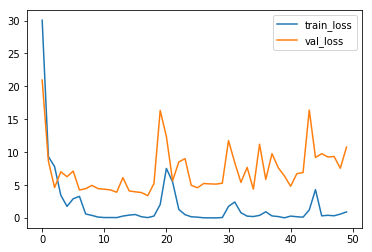

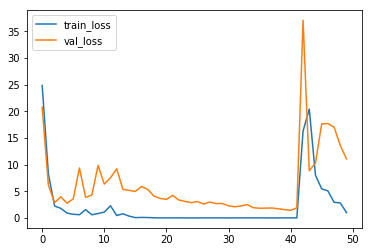

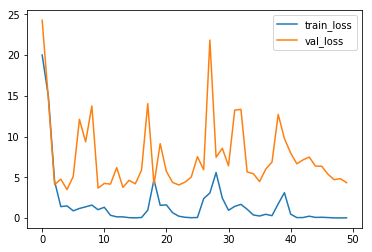

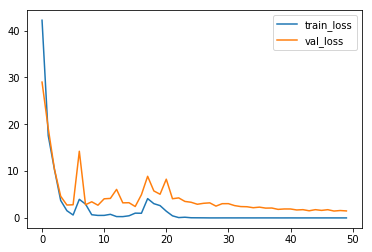

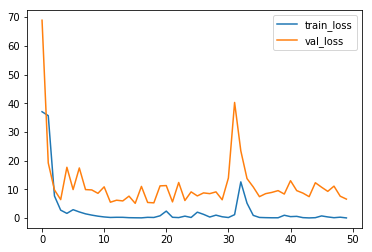

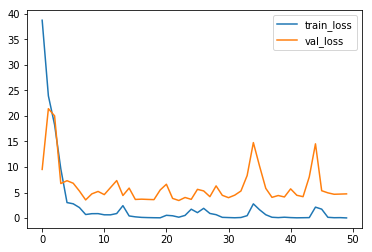

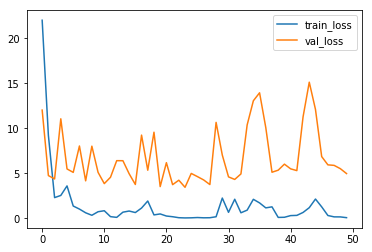

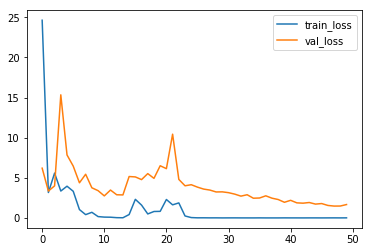

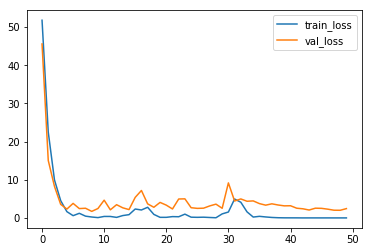

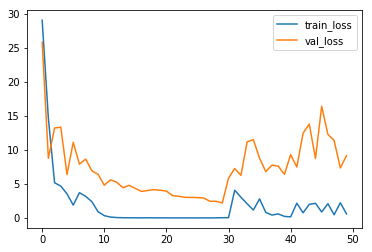

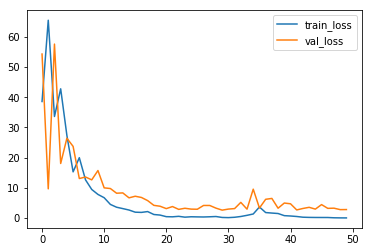

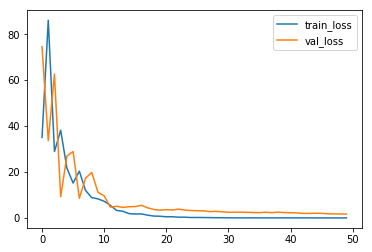

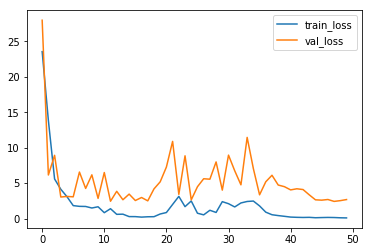

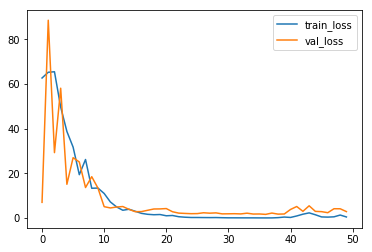

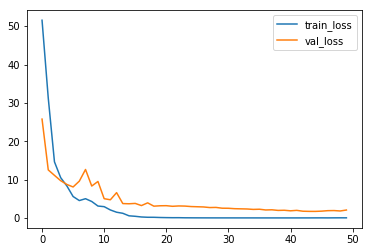

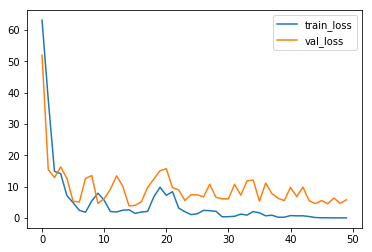

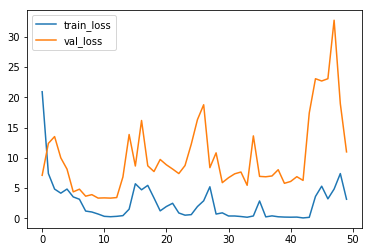

In [6]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

batch_sizes = [int(np.round(2 ** random.normalvariate(7,0.862519722))) for i in range(10)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(10)]
stats = []

disable = False
epochs = 50
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    for i in range(5):
        model = LogisticRegression().cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        #amp_handle.wrap_optimizer(optimizer)
        criterion = nn.CrossEntropyLoss()
        #amp_handle = amp.init()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == 0:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

for i in range(len(batch_sizes)):
    print("{:.2f} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in len(stats[i])])))

In [ ]:
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
print(dataVal.shape)
disable = False
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
vloss, vacc = test(model,criterion,my_val_loader,disable)
print("Validation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(vloss,vacc))

In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
with open('logregoutprob.pt', 'wb') as f:
    pickle.dump(answers, f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('logregout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))

In [ ]:
import pickle
import csv

with open('AffonsoNetoutprobs.pt', 'rb') as f:
    outvals = pickle.load(f)
# print(outvals)
ratings = []
headers = []
indices = []

with open('ratingsave.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            headers = row
            line_count += 1
        else:
            cur = []
            for i in range(-3,0):
                cur.append(row[i])
            ratings.append(cur)
            if cur[0] != "#DIV/0!":
                indices.append(line_count - 1)
            line_count += 1
    print(f'Processed {line_count} lines.')
# print(ratings)

_r = []
_o = []
for i in indices:
    _r.append([float(r) for r in ratings[i]])
    _o.append(outvals[i])
ratings = np.array(_r)
ratings = (ratings - np.ones(ratings.shape)) / 3.0
outvals = np.array(_o)
outvals = outvals.reshape((outvals.shape[0],1))
# print(ratings)
# print(ratings.shape,outvals.shape)
ratings = np.append(ratings,outvals,axis = 1)
# print(ratings.shape,outvals.shape)

res = np.corrcoef(ratings.T)
print(res)